<a href="https://colab.research.google.com/github/signofcommunication/Bible-of-Competitive-Programming/blob/main/Lipstick_Enhancement_Fiola_Arta_Gloria_Saranani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install mediapipe opencv-python matplotlib numpy

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display

In [ ]:
# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [ ]:
# Define lip landmarks indices (from Mediapipe Face Mesh)
LIP_LANDMARKS = [
    # Outer lip
    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 409, 270, 269, 267, 0, 37, 39, 40, 185,
    # Inner lip
    78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191
]

In [ ]:
# Function to extract lip region and compute dominant color in HSV
def analyze_lip_color(image):
    # Convert to RGB for Mediapipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process with Face Mesh
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        raise ValueError("No face detected in the image.")

    face_landmarks = results.multi_face_landmarks[0]

    # Get image dimensions
    height, width, _ = image.shape

    # Extract lip landmarks points
    lip_points = []
    for idx in LIP_LANDMARKS:
        lm = face_landmarks.landmark[idx]
        x = int(lm.x * width)
        y = int(lm.y * height)
        lip_points.append((x, y))

    # Create a mask for the lip region
    lip_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillConvexPoly(lip_mask, np.array(lip_points), 255)

    # Extract lip region using the mask
    lip_region = cv2.bitwise_and(image, image, mask=lip_mask)

    # Convert to HSV
    lip_hsv = cv2.cvtColor(lip_region, cv2.COLOR_BGR2HSV)

    # Compute mean HSV values (ignoring black pixels where mask is 0)
    non_zero_pixels = lip_hsv[lip_mask > 0]
    if len(non_zero_pixels) == 0:
        raise ValueError("No valid lip pixels found.")

    mean_hsv = np.mean(non_zero_pixels, axis=0)

    return mean_hsv, lip_points

# Define rule-based expert system (using dictionary)
# Rules based on HSV: Hue (0-360, but in OpenCV 0-180), Saturation (0-255), Value (0-255)
# Simple categories:
# - Pinkish: Hue around 160-180 (pink/red)
# - Dark: Low Value (<100)
# - Etc. (Can be edited)
lipstick_rules = {
    'pinkish': {'condition': lambda hsv: 150 <= hsv[0] <= 180, 'recommendation': 'Pink Muda', 'color': (255, 182, 193)},  # Light Pink RGB
    'dark': {'condition': lambda hsv: hsv[2] < 100, 'recommendation': 'Nude atau Peach', 'color': (255, 218, 185)},  # Peach RGB
    'reddish': {'condition': lambda hsv: 0 <= hsv[0] <= 10 or 170 <= hsv[0] <= 180, 'recommendation': 'Merah Muda', 'color': (255, 105, 180)},  # Hot Pink
    'default': {'recommendation': 'Natural', 'color': (210, 180, 140)}  # Tan
}

In [ ]:
# Function to get recommendation
def get_lipstick_recommendation(mean_hsv):
    for key, rule in lipstick_rules.items():
        if key != 'default' and rule['condition'](mean_hsv):
            return rule['recommendation'], rule['color']
    return lipstick_rules['default']['recommendation'], lipstick_rules['default']['color']

# Function to draw lip detection on image
def draw_lip_detection(image, lip_points):
    image_copy = image.copy()
    cv2.polylines(image_copy, [np.array(lip_points)], isClosed=True, color=(0, 255, 0), thickness=2)
    return image_copy

Upload gambar wajah (format JPG/PNG):


Saving Ari Kun.jpg to Ari Kun.jpg
Warna bibir dominan (HSV mean): [41.45539648 71.42786344 68.80011013]
Rekomendasi lipstik: Nude atau Peach


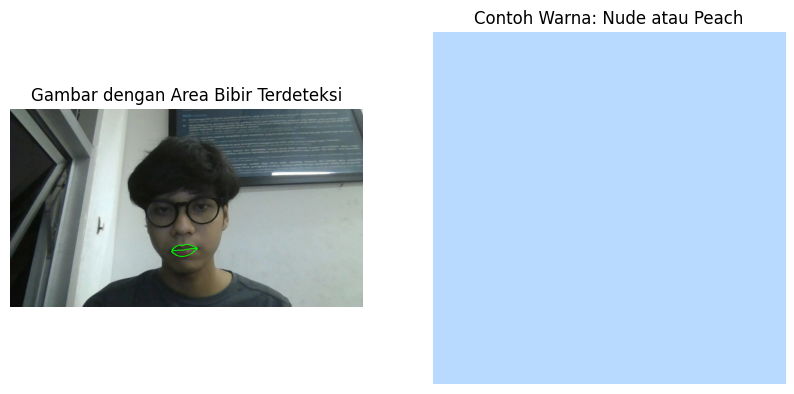

In [ ]:
# Main execution
def main():
    # Upload image
    print("Upload gambar wajah (format JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("Tidak ada gambar yang diupload.")
        return

    # Get the first uploaded file
    file_name = next(iter(uploaded))
    image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)

    try:
        # Analyze lip color
        mean_hsv, lip_points = analyze_lip_color(image)
        print(f"Warna bibir dominan (HSV mean): {mean_hsv}")

        # Get recommendation
        recommendation, color_rgb = get_lipstick_recommendation(mean_hsv)
        print(f"Rekomendasi lipstik: {recommendation}")

        # Draw detection
        detected_image = draw_lip_detection(image, lip_points)

        # Display original image with detection
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title("Gambar dengan Area Bibir Terdeteksi")
        plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Display recommended color swatch
        color_swatch = np.zeros((100, 100, 3), dtype=np.uint8)
        color_swatch[:] = color_rgb
        plt.subplot(1, 2, 2)
        plt.title(f"Contoh Warna: {recommendation}")
        plt.imshow(cv2.cvtColor(color_swatch, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

    except ValueError as e:
        print(f"Error: {e}")

# Run the main function
main()